In [36]:
import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import silhouette_samples, silhouette_score

In [19]:
# Carregando o conjunto de dados
# Importante que para rodar é preciso que o arquivo esteja na mesma pasta que o notebook
df = pd.read_csv('../data/zoo.data', sep=",", header=None)

# Selecionando as classes que desejamos
targets = df.iloc[:, 17]

# Selecionando apenas os valores do dataset que devem participar da análise
df = df.iloc[:, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,16]]

# Convertendo o dataframe para uma matriz NumPy e atribui o tipo float aos dados
data = df.values
X = data.astype(float)

# Normalizando o Dataset
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
df_normalized = pd.DataFrame(X)

# Pondo apenas 3 valores
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca)

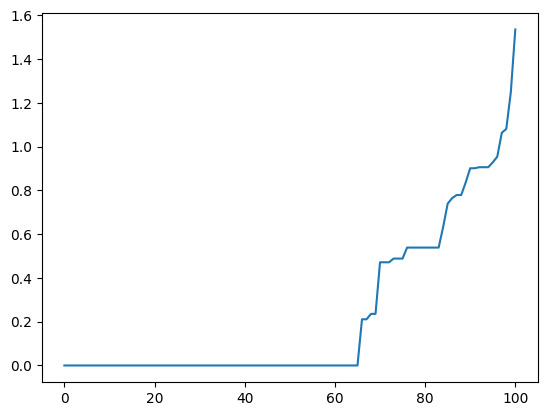

In [26]:
# Vamos agora calcular a melhor distancia entre pontos
# Para isso vamos verificar os dois vizinhos mais proximos de capa ponto do dataset, depois ajustar op modelo
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_pca)
distances, indices = nbrs.kneighbors(df_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
# Por fim vamos verificar o melhor ponto no gráfico
plt.plot(distances)

In [49]:
# Vamos criar agora uma funcao para visualizar os dados
def showGraph(eps, min_samples):
  # Aplicando o DBSCAM
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
  dbscan.fit(df_pca)
  labels = dbscan.labels_
  # Exibindo as variáveis usadas numero de clusters e ruído
  n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise = list(labels).count(-1)
  print('eps:', eps)
  print('Número de clusters:', n_clusters)
  print('Número de amostras de ruído:', n_noise)
  # Criando uma figura 3D
  fig = plt.figure(figsize = (8, 8))
  ax = fig.add_subplot(111, projection='3d')
  # Plotando os dados em um gráfico de dispersão 3D
  ax.scatter(df_pca[0], df_pca[1], df_pca[2], c=labels, cmap='viridis')
  # Definindo rótulos de eixo e título do gráfico
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_title('Resultado do DBSCAN em 3D')
  # Exibindo gráfico
  plt.show()

(6, 5, 1.4000000000000006)
eps: 1.4000000000000006
Número de clusters: 6
Número de amostras de ruído: 5


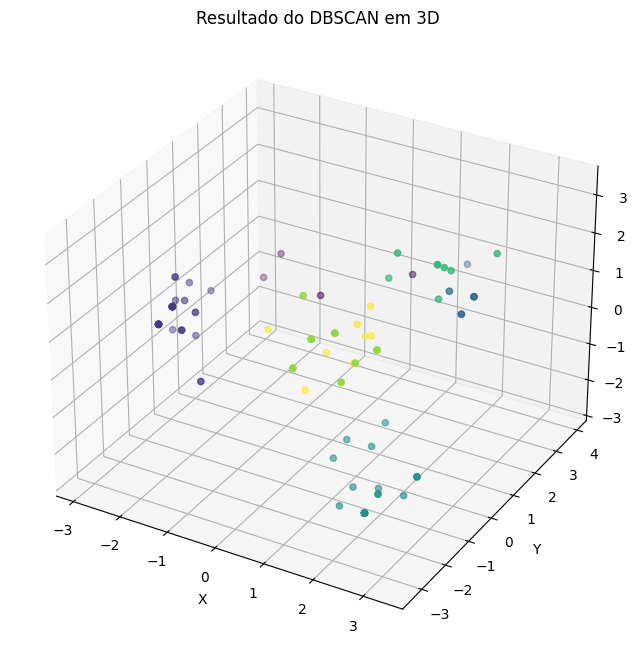

In [51]:
# Vimos pelo gráfico que possivelmente o melhor valor para as distancias está entre 0.1 e 1.4
lista_eps = np.arange(0.1, 1.5 + 0.05, 0.05).tolist()

best = (0,99999, 0) # Uma variável como a pior possível para encontrar o melhor

for eps in lista_eps:
    # Criando uma instância do modelo DBSCAN com os parametros selecionados
    dbscan = DBSCAN(eps=eps, min_samples=5)
    # Ajustando o modelo aos dados
    dbscan.fit(df_pca)
    # Guardando as etiquetas de classe atribuídas a cada amostra
    labels = dbscan.labels_
    # Definindo e imprimindo o número de clusters e o número de amostras de ruído
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    if (n_clusters > best[0]) or (n_clusters == best[0] and n_noise < best[1]):
      best = (n_clusters, n_noise, eps)

#Exibindo o melhor resultado obtido
print(best)
best_eps = best[2]
showGraph(best_eps,5)

eps: 1.4000000000000006
Número de clusters: 6
Número de amostras de ruído: 1


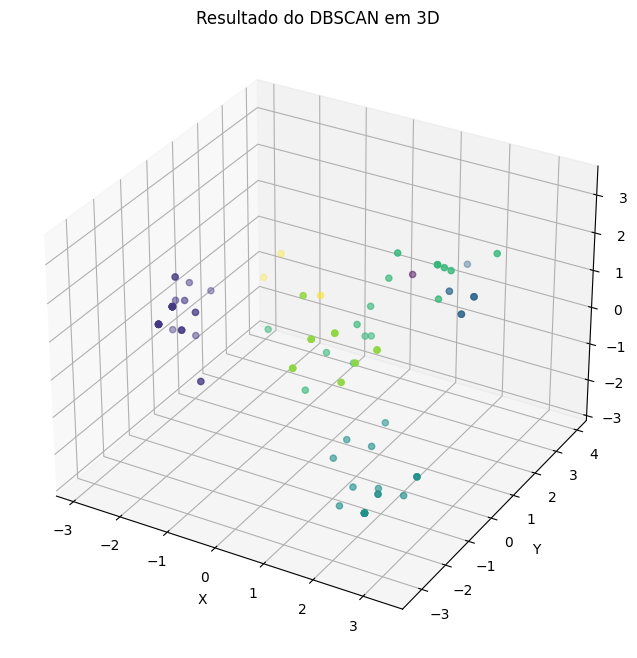

In [57]:
# Encontrando o melhor número mínimo para uma classe
bestSamples = (9999, -1)
for i in range(2,10):
    dbscan = DBSCAN(eps=best_eps, min_samples=i)
    dbscan.fit(df_pca)
    labels = dbscan.labels_

    # Calcula o índice Silhouette para os rótulos gerados
    silhouette = silhouette_score(df_pca, labels)

    # Define a melhor escolha
    if silhouette <= bestSamples[0] and silhouette >= 0:
      bestSamples = (silhouette, i)

best_mS = bestSamples[1]

showGraph(best_eps, best_mS)